In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import scvi
from matplotlib_venn import venn2

from utils import enrich, enrichr

Global seed set to 0


In [2]:
sc.set_figure_params(dpi=100, frameon=False, color_map='Reds', facecolor=None)
sc.logging.print_header()

/home/icb/yuge.ji/miniconda3/envs/py37/lib/python3.7/site-packages/scanpy/_settings.py:447: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  IPython.display.set_matplotlib_formats(*ipython_format)
2022-05-04 05:49:13.503440: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-04 05:49:13.503502: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


scanpy==1.8.2 anndata==0.7.6 umap==0.5.2 numpy==1.20.3 scipy==1.5.3 pandas==1.3.4 scikit-learn==1.0.2 statsmodels==0.11.1 python-igraph==0.8.3 leidenalg==0.8.3 pynndescent==0.5.5


## Load data

We previously combined the epithelial cells in fischer with our ALI dataset in the `2021-10-01_scanvi_label_mapping` notebook.

In [3]:
adata = sc.read('2022-03-30_covid_fischer_scanvi_subset.h5ad')
adata

AnnData object with n_obs × n_vars = 284300 × 18023
    obs: 'identifier', 'patient', 'name', 'barcode_round', 'sample', 'viral_counts', 'treatment', 'treatment_virus', 'infected', 'n_counts', 'n_genes', 'percent_mito', 'percent_viral', 'leiden', 'final_bcs', 'batch', 'celltype_coarse', 'cell_type', 'infection_label', '_scvi_batch', '_scvi_labels', '_scvi_local_l_mean', '_scvi_local_l_var', 'batch_data', 'patients', 'sample_ID', 'data_set', 'severity', 'location', 'condition', 'age', 'sex', 'virus_positive', 'PBMC_leiden_29', 'patient_category', 'reactive_clonotype', 'published_meta_celltype', 'published_celltype', 'harmonized_celltype', 'T_cell_type', 'size_factors', 'pct_mitochondrial', 'severity_virus'
    var: 'used_for_scvi-0', 'highly_variable-1', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'hvg'
    obsm: 'X_pca', 'X_umap'
    layers: 'counts'

### Look at data

Trying to set attribute `.uns` of view, copying.


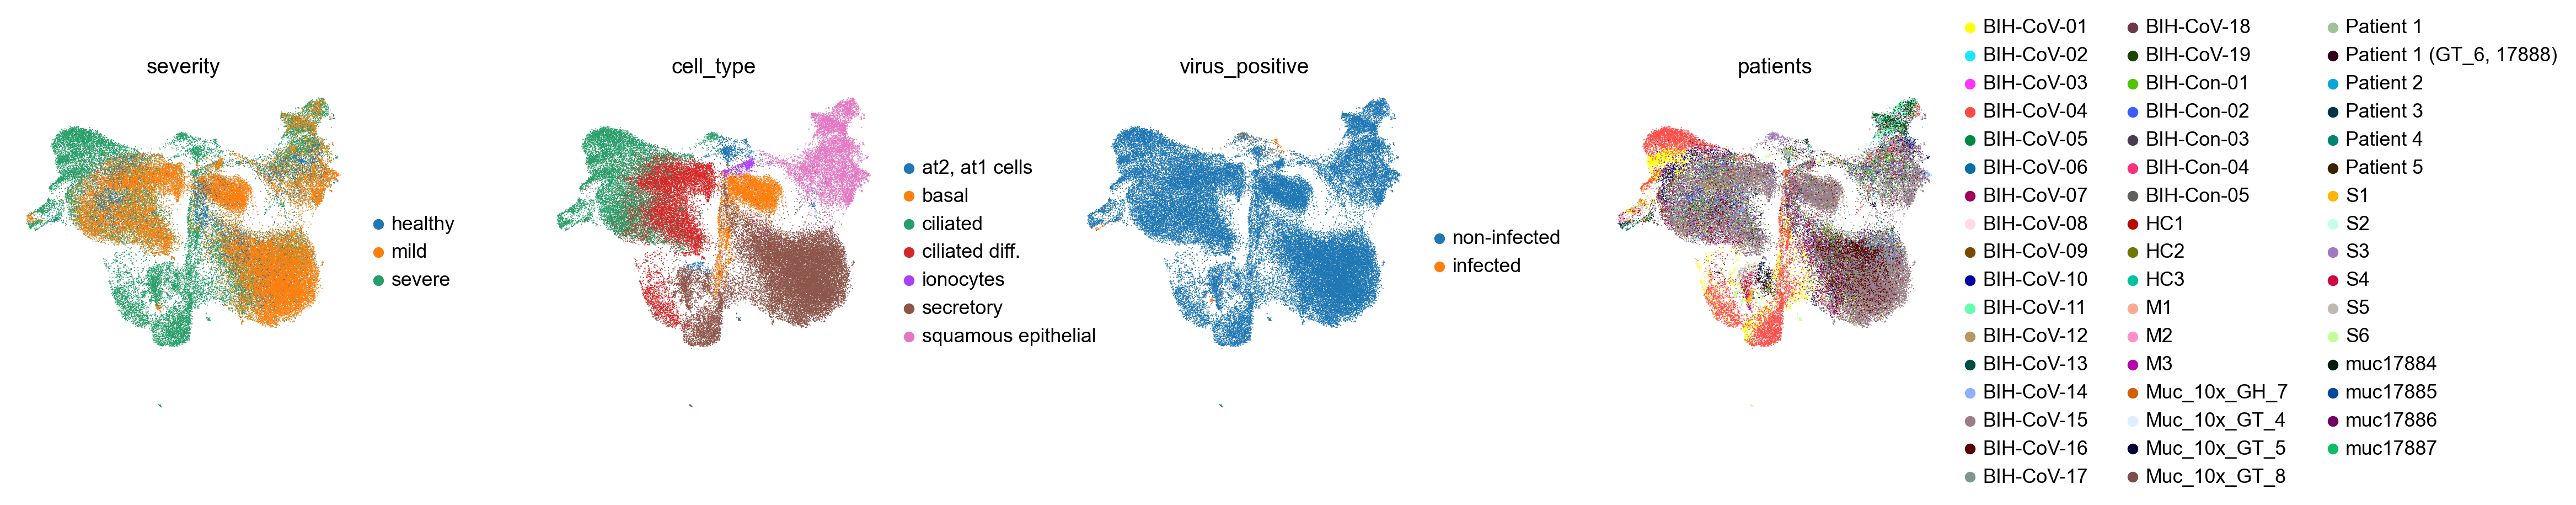

In [4]:
sc.pl.umap(adata[adata.obs.batch_data == 'fischer'], color=['severity', 'cell_type', 'virus_positive', 'patients'], wspace=.4)

Trying to set attribute `.uns` of view, copying.


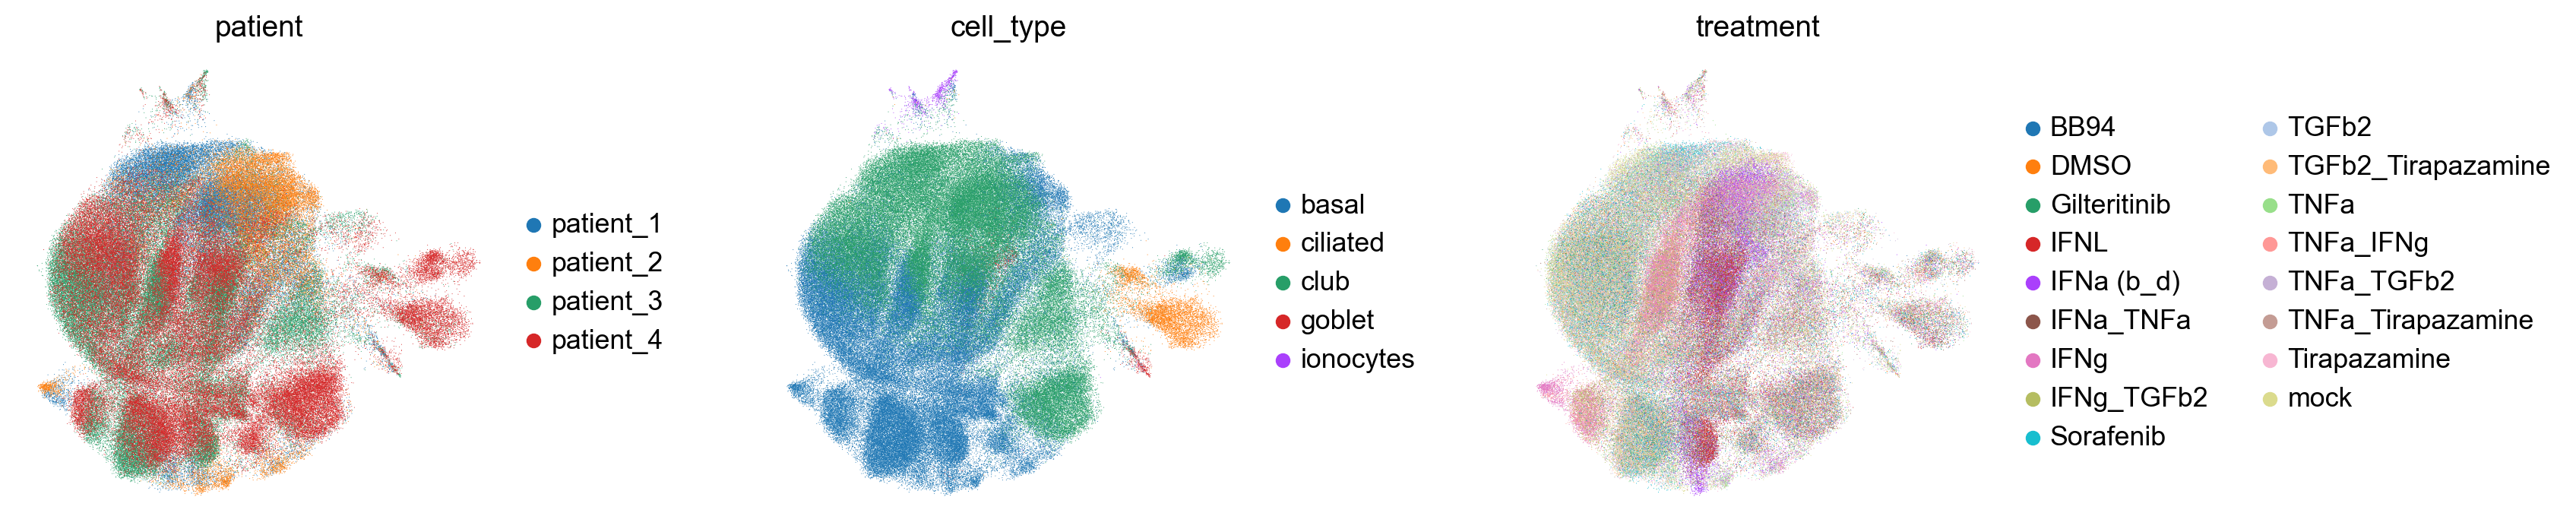

In [5]:
sc.pl.umap(adata[adata.obs.batch_data != 'fischer'], color=['patient', 'cell_type', 'treatment'], wspace=.4)

### Subset ALI data to just cytokine treatments (since we can't quite interpret the perturbations)

In [6]:
adata = adata[~adata.obs.treatment.isin(['BB94', 'Gilteritinib', 'Sorafenib', 'TGFb2_Tirapazamine', 'TNFa_Tirapazamine', 'Tirapazamine'])]
adata

View of AnnData object with n_obs × n_vars = 224506 × 18023
    obs: 'identifier', 'patient', 'name', 'barcode_round', 'sample', 'viral_counts', 'treatment', 'treatment_virus', 'infected', 'n_counts', 'n_genes', 'percent_mito', 'percent_viral', 'leiden', 'final_bcs', 'batch', 'celltype_coarse', 'cell_type', 'infection_label', '_scvi_batch', '_scvi_labels', '_scvi_local_l_mean', '_scvi_local_l_var', 'batch_data', 'patients', 'sample_ID', 'data_set', 'severity', 'location', 'condition', 'age', 'sex', 'virus_positive', 'PBMC_leiden_29', 'patient_category', 'reactive_clonotype', 'published_meta_celltype', 'published_celltype', 'harmonized_celltype', 'T_cell_type', 'size_factors', 'pct_mitochondrial', 'severity_virus'
    var: 'used_for_scvi-0', 'highly_variable-1', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'hvg'
    obsm: 'X_pca', 'X_umap'
    layers: 'counts'

Trying to set attribute `.uns` of view, copying.


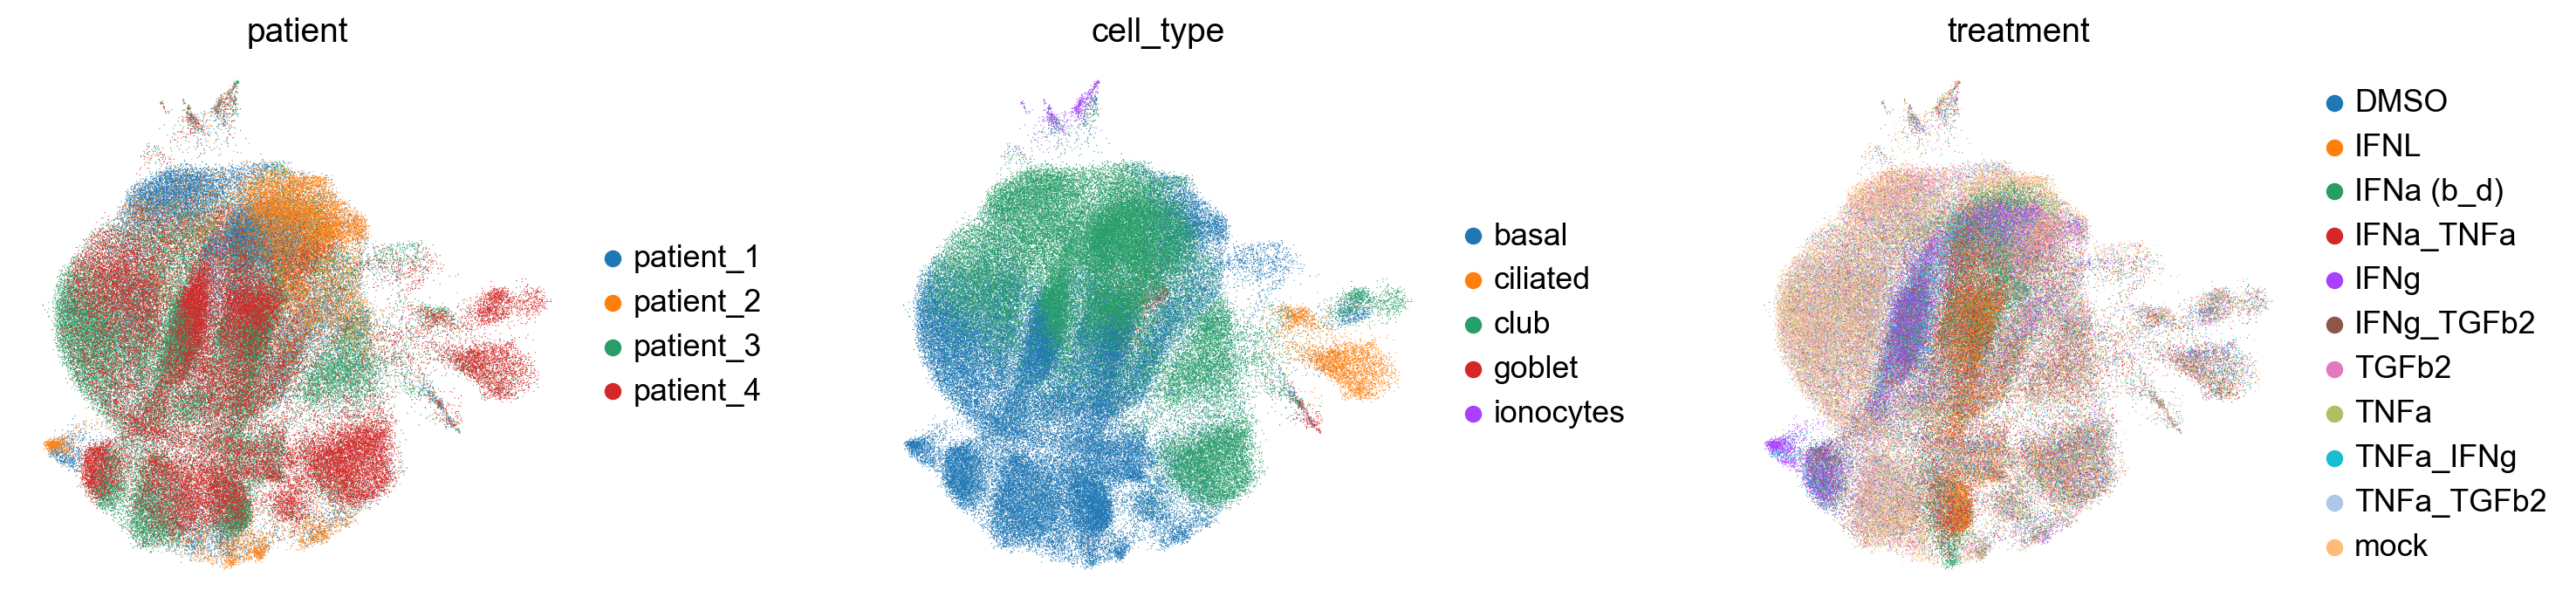

In [7]:
sc.pl.umap(adata[adata.obs.batch_data != 'fischer'], color=['patient', 'cell_type', 'treatment'], wspace=.4)

## Train

Since I haven't done a comparison of whether or not we can approximate this training procedure with a single model, we will loop training for now.

In [8]:
from sklearn.linear_model import LogisticRegression
from external_utils import define_marker_genes

training IFNa_TNFa model...


/home/icb/yuge.ji/miniconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


regression trained on (46138, 18023)
performance on training: 0.9757466730244051


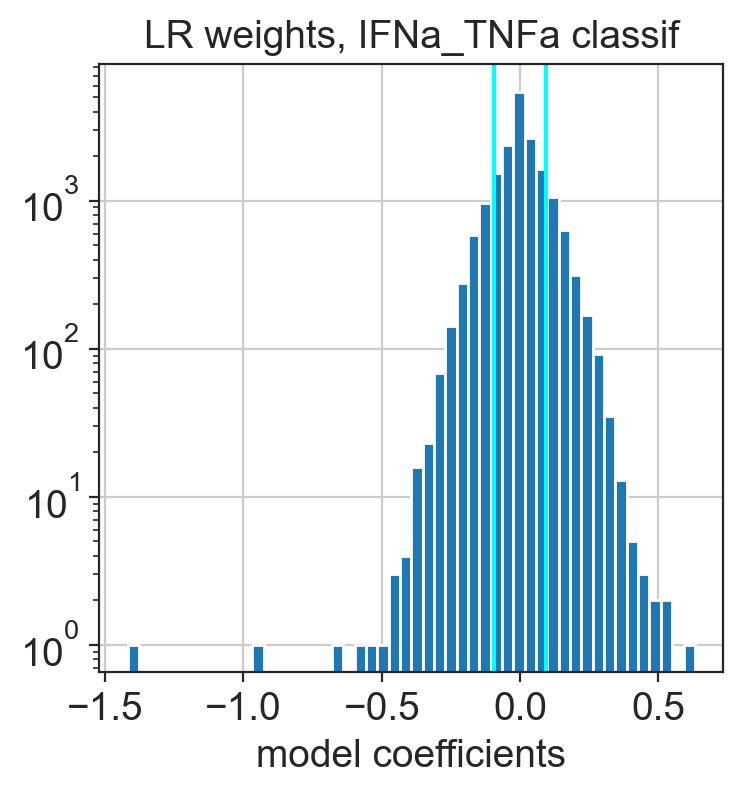

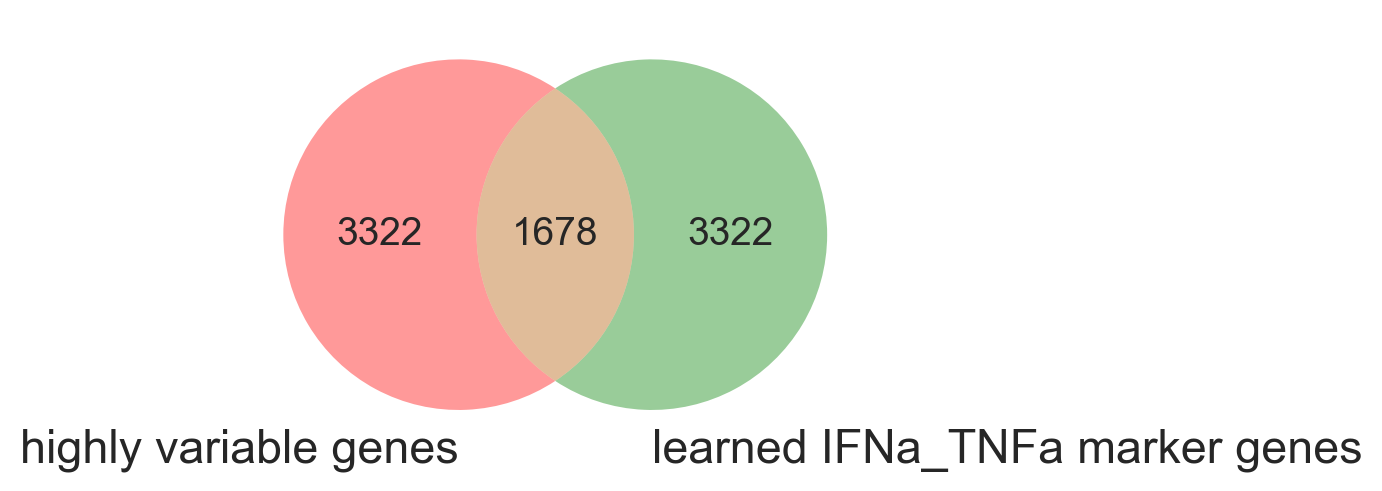

INFO     Using batches from adata.obs["batch_data"]                                          
INFO     Using labels from adata.obs["treatment_scanvi"]                                     
INFO     Using data from adata.layers["counts"]                                              


/home/icb/yuge.ji/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


INFO     Successfully registered anndata object containing 224506 cells, 18023 vars, 5       
         batches, 12 labels, and 0 proteins. Also registered 0 extra categorical covariates  
         and 0 extra continuous covariates.                                                  
INFO     Please do not further modify adata until model is trained.                          


/home/icb/yuge.ji/miniconda3/envs/py37/lib/python3.7/site-packages/scvi/model/base/_base_model.py:151: UserWarning: Make sure the registered X field in anndata contains unnormalized count data.
  "Make sure the registered X field in anndata contains unnormalized count data."


INFO     Training for 40 epochs.                                                             


GPU available: False, used: False
TPU available: False, using: 0 TPU cores


Epoch 1/40:   0%|                                                                                                                                                                                                                    | 0/40 [00:00<?, ?it/s]

/home/icb/yuge.ji/miniconda3/envs/py37/lib/python3.7/site-packages/scvi/distributions/_negative_binomial.py:435: UserWarning: The value argument must be within the support of the distribution
  UserWarning,


Epoch 40/40: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [1:16:10<00:00, 114.26s/it, loss=4.63e+03, v_num=1]

/home/icb/yuge.ji/miniconda3/envs/py37/lib/python3.7/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'treatment_scanvi' as categorical



training TNFa model...


/home/icb/yuge.ji/miniconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


regression trained on (48668, 18023)
performance on training: 0.8475795183693597


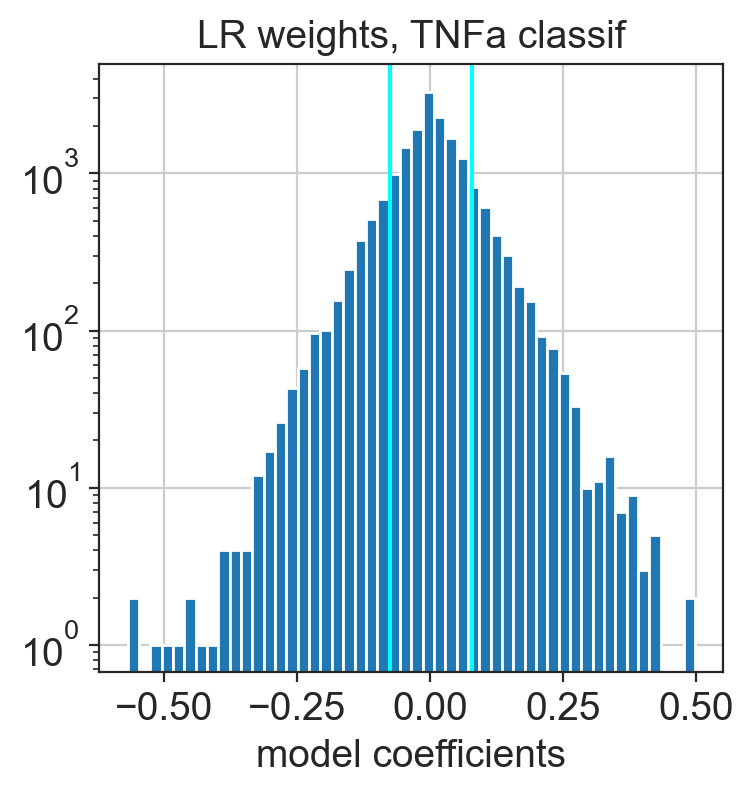

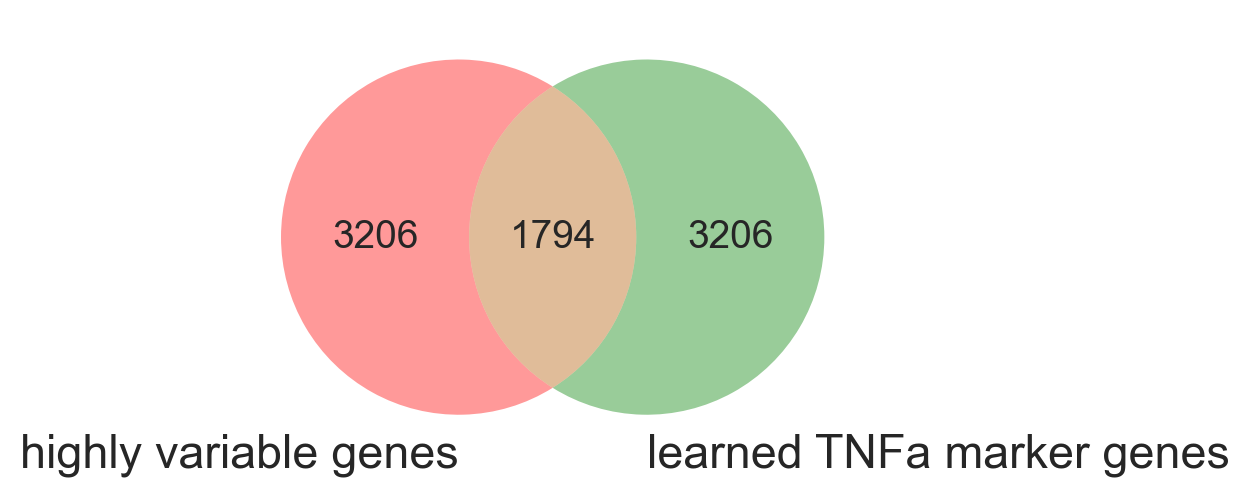

INFO     Using batches from adata.obs["batch_data"]                                          
INFO     Using labels from adata.obs["treatment_scanvi"]                                     
INFO     Using data from adata.layers["counts"]                                              


/home/icb/yuge.ji/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


INFO     Successfully registered anndata object containing 224506 cells, 18023 vars, 5       
         batches, 12 labels, and 0 proteins. Also registered 0 extra categorical covariates  
         and 0 extra continuous covariates.                                                  
INFO     Please do not further modify adata until model is trained.                          


/home/icb/yuge.ji/miniconda3/envs/py37/lib/python3.7/site-packages/scvi/model/base/_base_model.py:151: UserWarning: Make sure the registered X field in anndata contains unnormalized count data.
  "Make sure the registered X field in anndata contains unnormalized count data."


INFO     Training for 40 epochs.                                                             


GPU available: False, used: False
TPU available: False, using: 0 TPU cores


Epoch 1/40:   0%|                                                                                                                                                                                                                    | 0/40 [00:00<?, ?it/s]

/home/icb/yuge.ji/miniconda3/envs/py37/lib/python3.7/site-packages/scvi/distributions/_negative_binomial.py:435: UserWarning: The value argument must be within the support of the distribution
  UserWarning,


Epoch 40/40: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [1:12:46<00:00, 109.17s/it, loss=4.62e+03, v_num=1]

/home/icb/yuge.ji/miniconda3/envs/py37/lib/python3.7/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'treatment_scanvi' as categorical



training TGFb2 model...


/home/icb/yuge.ji/miniconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


regression trained on (49331, 18023)
performance on training: 0.8220794226753968


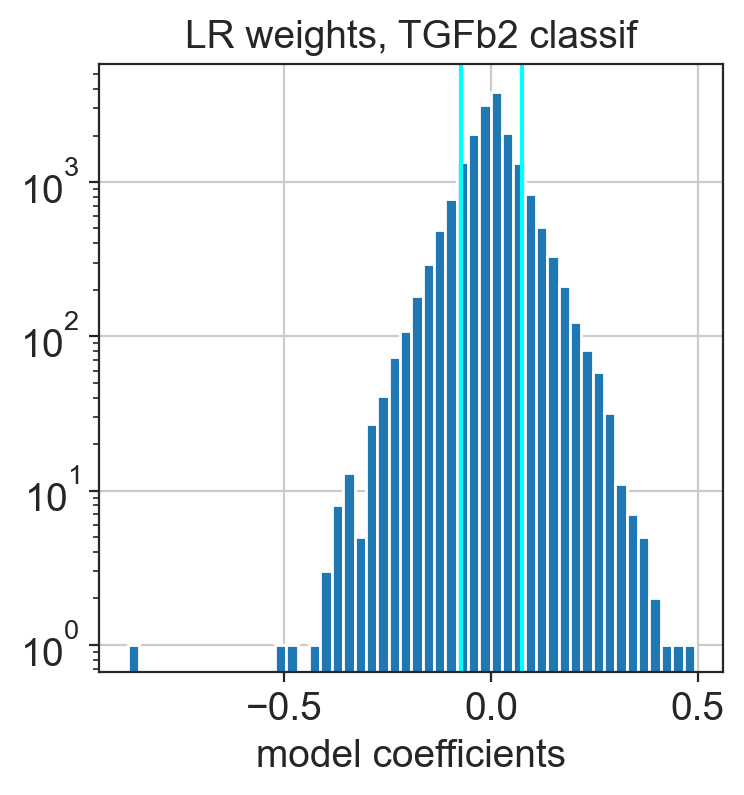

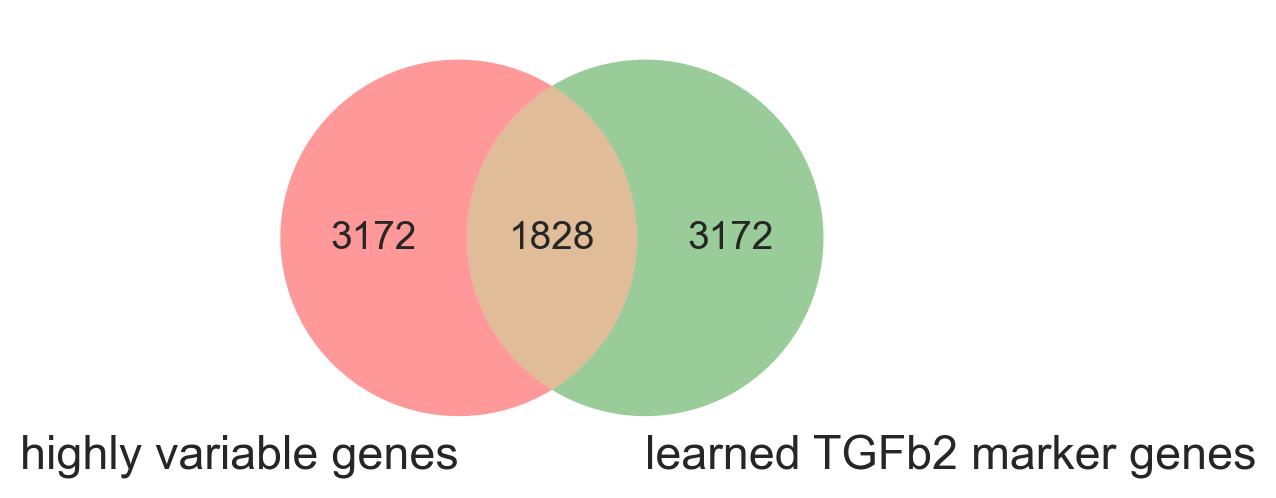

INFO     Using batches from adata.obs["batch_data"]                                          
INFO     Using labels from adata.obs["treatment_scanvi"]                                     
INFO     Using data from adata.layers["counts"]                                              


/home/icb/yuge.ji/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


INFO     Successfully registered anndata object containing 224506 cells, 18023 vars, 5       
         batches, 12 labels, and 0 proteins. Also registered 0 extra categorical covariates  
         and 0 extra continuous covariates.                                                  
INFO     Please do not further modify adata until model is trained.                          


/home/icb/yuge.ji/miniconda3/envs/py37/lib/python3.7/site-packages/scvi/model/base/_base_model.py:151: UserWarning: Make sure the registered X field in anndata contains unnormalized count data.
  "Make sure the registered X field in anndata contains unnormalized count data."


INFO     Training for 40 epochs.                                                             


GPU available: False, used: False
TPU available: False, using: 0 TPU cores


Epoch 1/40:   0%|                                                                                                                                                                                                                    | 0/40 [00:00<?, ?it/s]

/home/icb/yuge.ji/miniconda3/envs/py37/lib/python3.7/site-packages/scvi/distributions/_negative_binomial.py:435: UserWarning: The value argument must be within the support of the distribution
  UserWarning,


Epoch 40/40: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [1:18:08<00:00, 117.20s/it, loss=4.64e+03, v_num=1]


/home/icb/yuge.ji/miniconda3/envs/py37/lib/python3.7/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'treatment_scanvi' as categorical


training TNFa_TGFb2 model...


/home/icb/yuge.ji/miniconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


regression trained on (43055, 18023)
performance on training: 0.9170363488561143


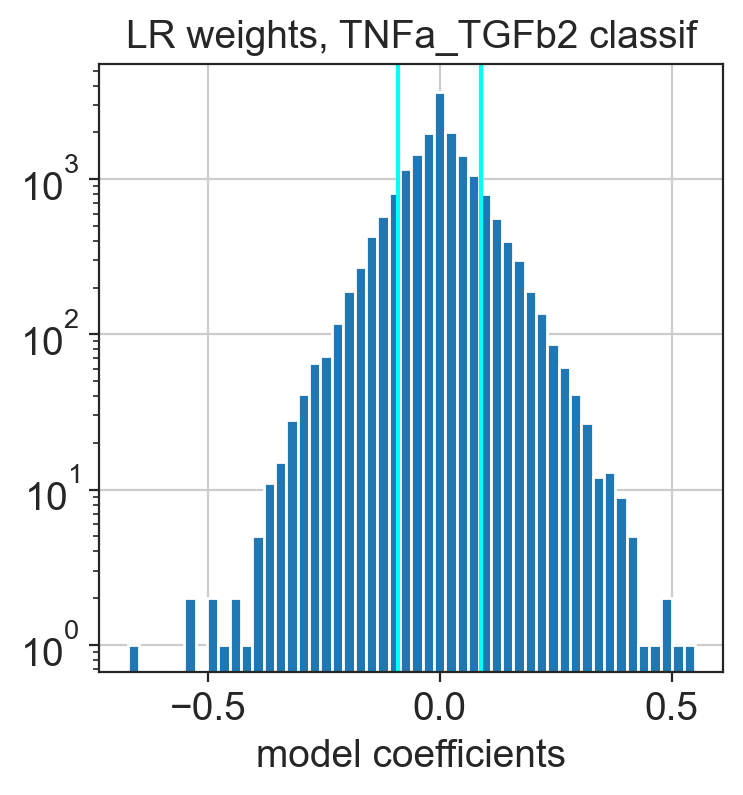

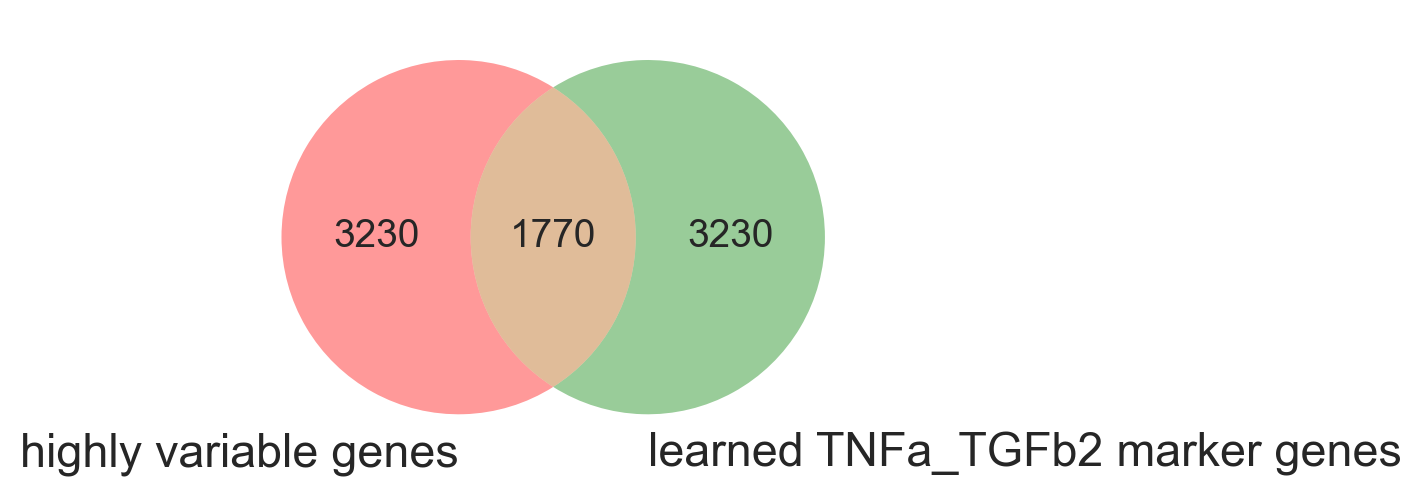

INFO     Using batches from adata.obs["batch_data"]                                          
INFO     Using labels from adata.obs["treatment_scanvi"]                                     
INFO     Using data from adata.layers["counts"]                                              


/home/icb/yuge.ji/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


INFO     Successfully registered anndata object containing 224506 cells, 18023 vars, 5       
         batches, 12 labels, and 0 proteins. Also registered 0 extra categorical covariates  
         and 0 extra continuous covariates.                                                  
INFO     Please do not further modify adata until model is trained.                          


/home/icb/yuge.ji/miniconda3/envs/py37/lib/python3.7/site-packages/scvi/model/base/_base_model.py:151: UserWarning: Make sure the registered X field in anndata contains unnormalized count data.
  "Make sure the registered X field in anndata contains unnormalized count data."


INFO     Training for 40 epochs.                                                             


GPU available: False, used: False
TPU available: False, using: 0 TPU cores


Epoch 1/40:   0%|                                                                                                                                                                                                                    | 0/40 [00:00<?, ?it/s]

/home/icb/yuge.ji/miniconda3/envs/py37/lib/python3.7/site-packages/scvi/distributions/_negative_binomial.py:435: UserWarning: The value argument must be within the support of the distribution
  UserWarning,


Epoch 40/40: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [1:24:59<00:00, 127.50s/it, loss=4.6e+03, v_num=1]


/home/icb/yuge.ji/miniconda3/envs/py37/lib/python3.7/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'treatment_scanvi' as categorical


training IFNL model...


/home/icb/yuge.ji/miniconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


regression trained on (40608, 18023)
performance on training: 0.9999261229314421


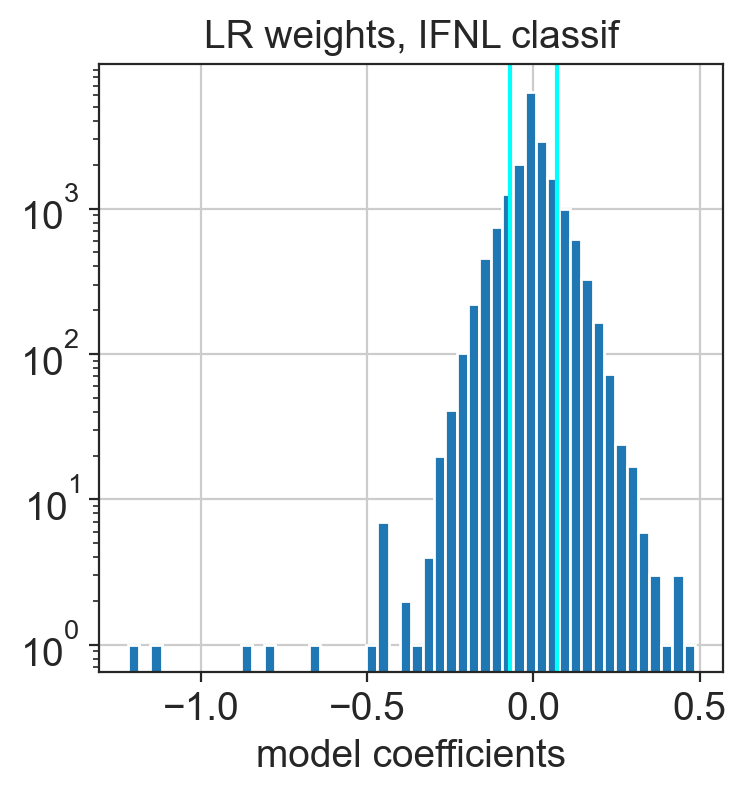

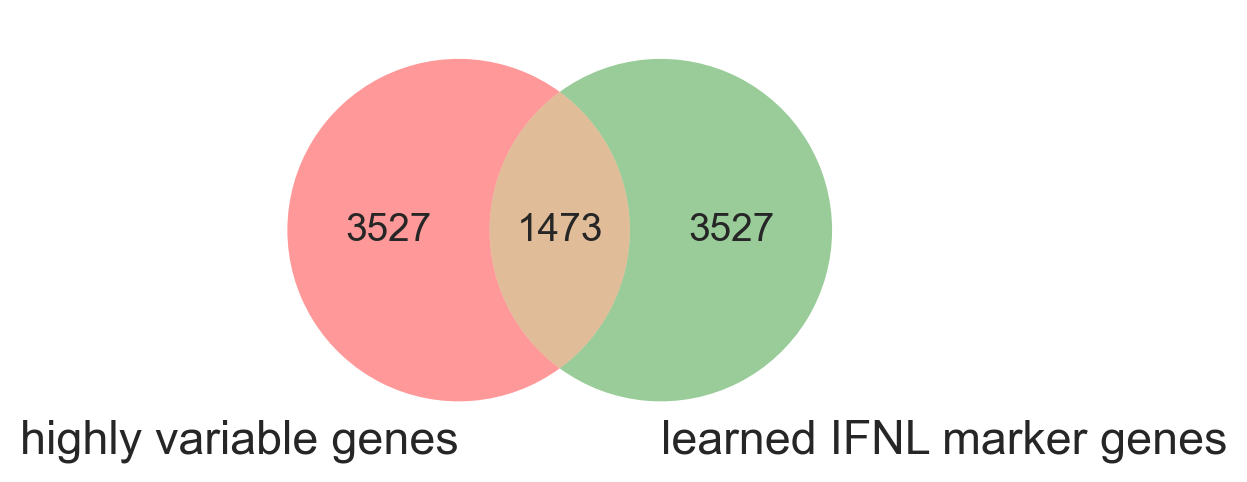

INFO     Using batches from adata.obs["batch_data"]                                          
INFO     Using labels from adata.obs["treatment_scanvi"]                                     
INFO     Using data from adata.layers["counts"]                                              


/home/icb/yuge.ji/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


INFO     Successfully registered anndata object containing 224506 cells, 18023 vars, 5       
         batches, 12 labels, and 0 proteins. Also registered 0 extra categorical covariates  
         and 0 extra continuous covariates.                                                  
INFO     Please do not further modify adata until model is trained.                          


/home/icb/yuge.ji/miniconda3/envs/py37/lib/python3.7/site-packages/scvi/model/base/_base_model.py:151: UserWarning: Make sure the registered X field in anndata contains unnormalized count data.
  "Make sure the registered X field in anndata contains unnormalized count data."


INFO     Training for 40 epochs.                                                             


GPU available: False, used: False
TPU available: False, using: 0 TPU cores


Epoch 1/40:   0%|                                                                                                                                                                                                                    | 0/40 [00:00<?, ?it/s]

/home/icb/yuge.ji/miniconda3/envs/py37/lib/python3.7/site-packages/scvi/distributions/_negative_binomial.py:435: UserWarning: The value argument must be within the support of the distribution
  UserWarning,


Epoch 37/40:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 36/40 [1:13:46<09:56, 149.23s/it, loss=4.6e+03, v_num=1]

In [ ]:
%%time
import os
for treatment in adata.obs.treatment.unique():
    if treatment == 'mock':
        continue

    ## check if model has already been trained
    if f'2022-04-15_scanvi_{treatment}_genes' in os.listdir('fischer_models'):
        continue
    
    print(f'training {treatment} model...')

    ## determine genes ##
    clf = LogisticRegression(solver='saga')

    subset = adata[adata.obs.treatment.isin([treatment, 'mock'])]  # covid data only
    clf.fit(subset.X.toarray(), subset.obs.treatment.values)
    print('regression trained on', subset.shape)
    
    print('performance on training:', clf.score(subset.X.toarray(), subset.obs.treatment.values))
    
    define_marker_genes(adata, clf)
    plt.title(f'LR weights, {treatment} classif')
    plt.show()
    
    venn2(
        [set(adata.var_names[adata.var['highly_variable']]), set(adata.var_names[adata.var['marker_genes']])], 
        set_labels=[f'highly variable genes', f'learned {treatment} marker genes']
    )
    plt.show()
    
    ## train scanvi model ##
    adata_var = adata[:, adata.var['marker_genes'] == True].copy()

    # set unknown label for scanvi
    adata.obs["treatment_scanvi"] = 'Unknown'
    fischer_idx = adata.obs['batch_data'] != "fischer"
    adata.obs["treatment_scanvi"][fischer_idx] = adata.obs.treatment[fischer_idx]
    
    scvi.model.SCANVI.setup_anndata(
        adata,
        layer="counts",
        batch_key="batch_data",
        labels_key="treatment_scanvi",
    )
    
    arches_params = dict(
        use_layer_norm="both",
        use_batch_norm="none",
        encode_covariates=True,
        dropout_rate=0.2,
        n_layers=2,
        n_latent=30,
    )

    lvae_lr = scvi.model.SCANVI(adata, "Unknown", **arches_params)
    lvae_lr.train(early_stopping=True, max_epochs=40)
    lvae_lr.save(f'fischer_models/2022-04-15_scanvi_{treatment}_genes', save_anndata=True)